In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.nonparametric import kaplan_meier_estimator

import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

In [51]:
training_data_imputed_df = pd.read_csv("training_data_imputed_simple_TRAIN.csv.gz") 
survival_data_100h = training_data_imputed_df[training_data_imputed_df['survival_time'] < 36]

In [52]:
survival_data_100h.shape

(85546, 169)

In [53]:
train_df, val_df = train_test_split(survival_data_100h, test_size=0.2, random_state=1)

In [54]:
X_train = train_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'survival_time'], axis=1)
y_time = train_df['survival_time'].clip(lower=0)
y_event = train_df['cdiff_30d_flag'].astype(bool)

(array([11899., 18372., 13634.,  7126.,  6238.,  3775.,  2837.,  2142.,
         1264.,  1149.]),
 array([ 0.        ,  3.59993056,  7.19986111, 10.79979167, 14.39972222,
        17.99965278, 21.59958333, 25.19951389, 28.79944444, 32.399375  ,
        35.99930556]),
 <BarContainer object of 10 artists>)

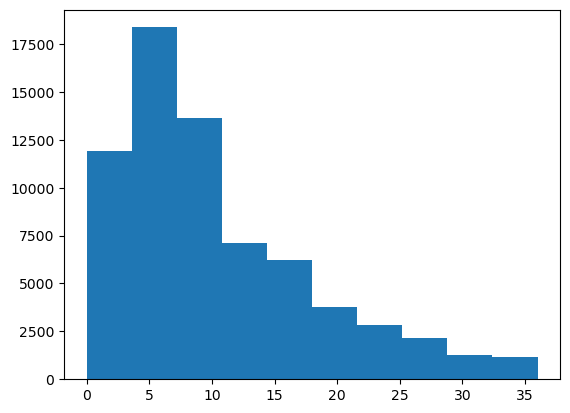

In [55]:
plt.hist(y_time)

Text(0.5, 0, 'time $t$ (days)')

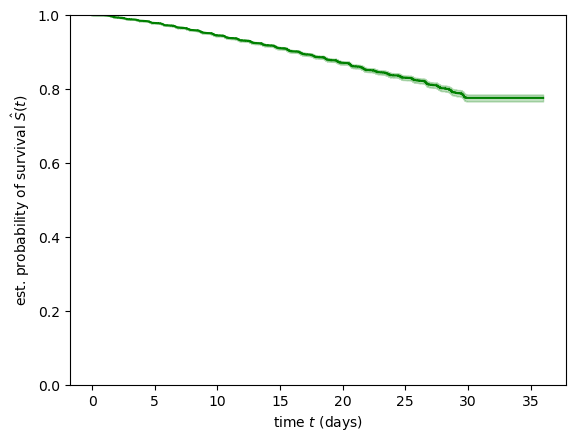

In [59]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    y_event, y_time, conf_type="log-log"
)
plt.step(time, survival_prob, color = "green")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post", color = "green")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (days)")

In [15]:
cox_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('cox', CoxPHSurvivalAnalysis())
])

In [3]:
# Train the Cox model
cox_pipe.fit(X_train, y_train)

# Evaluate on test set
cox_pred = cox_pipe.predict(X_test)
cox_cindex = concordance_index_censored(
    y_test['event'], y_test['time'], cox_pred)[0]
print(f"Cox model concordance index: {cox_cindex:.4f}")

NameError: name 'X_train' is not defined